In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())


C:\Users\GottaGoFaster\Documents\Python_Code_Showcase\Project_Showcase


# Data Import

In [2]:
# Load datasets
# Replace with the actual paths to your data files
dispatch_data = pd.read_csv('data/dispatch_data_with_issues.csv')
weather_data = pd.read_csv('data/weather_data_with_issues.csv')
traffic_data = pd.read_csv('data/traffic_data_with_issues.csv')

print(dispatch_data.shape)
print(weather_data.shape)
print(traffic_data.shape)

(500, 4)
(450, 4)
(400, 3)


In [3]:
# Display basic info
print("Dispatch Data Info:")
print(dispatch_data.info())
print("\nWeather Data Info:")
print(weather_data.info())
print("\nTraffic Data Info:")
print(traffic_data.info())


Dispatch Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dispatch_id    500 non-null    int64 
 1   location_id    500 non-null    int64 
 2   job_type       489 non-null    object
 3   dispatch_time  500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    450 non-null    int64  
 1   date           450 non-null    object 
 2   temperature    439 non-null    float64
 3   precipitation  450 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 14.2+ KB
None

Traffic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (

In [4]:
# Preview data
print("\nDispatch Data Preview:")
print(dispatch_data.head())
print("\nWeather Data Preview:")
print(weather_data.head())
print("\nTraffic Data Preview:")
print(traffic_data.head())



Dispatch Data Preview:
   dispatch_id  location_id       job_type                  dispatch_time
0            1          106  fuel_delivery  2024-01-02 08:47:37.867155968
1            2          106  fuel_delivery  2024-01-03 23:29:39.787000320
2            3          112    tire_change  2024-01-03 11:09:58.744973312
3            4          113   battery_jump  2024-01-01 12:23:25.783618048
4            5          111        lockout  2024-01-01 15:50:39.269447424

Weather Data Preview:
   location_id                 date  temperature  precipitation
0          106  2024-01-01 00:00:00         72.3           1.85
1          112  2024-01-02 00:00:00         90.3           0.96
2          111  2024-01-03 00:00:00         72.2           4.50
3          116  2024-01-03 00:00:00         71.4           3.21
4          115  2024-01-01 00:00:00         74.7           0.00

Traffic Data Preview:
   location_id                 date traffic_level
0          104  2024-01-01 00:00:00          high
1 

# EDA by dataset

In [5]:
# Dispatch data EDA

# Known valid job types
valid_job_types = ["towing", "fuel_delivery", "battery_jump", "lockout", "tire_change"]

print("=== DISPATCH DATA EDA ===\n")

# 1) Missing Values in All Columns
print("1) Missing values across columns:")
print(dispatch_data.isnull().sum())
print("-"*50)

# 2) Invalid or Missing Job Types
#   a) Missing (NaN)
missing_job_types = dispatch_data[dispatch_data['job_type'].isnull()]
#   b) Not in valid list (and not null)
invalid_job_types = dispatch_data[~dispatch_data['job_type'].isin(valid_job_types) & 
                                  dispatch_data['job_type'].notnull()]

print("2) Invalid or missing job_type rows:")
if not missing_job_types.empty:
    print("\n- Missing job_type rows:")
    print(missing_job_types)
if not invalid_job_types.empty:
    print("\n- job_type not in valid list:")
    print(invalid_job_types)
if missing_job_types.empty and invalid_job_types.empty:
    print("No invalid or missing job_type rows found.")
print("-"*50)

# 3) Invalid location IDs (e.g., not between 101 and 116)
invalid_location_ids = dispatch_data[~dispatch_data['location_id'].between(101, 116)]
print("3) Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# 4) Invalid dispatch_time (non-parsable or missing)
#   We'll coerce errors to NaT; rows where dispatch_time = NaT are invalid
dispatch_data['parsed_time'] = pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce')
invalid_dispatch_time = dispatch_data[dispatch_data['parsed_time'].isnull()]

print("4) Invalid dispatch_time rows:")
if invalid_dispatch_time.empty:
    print("No invalid dispatch_time rows found.")
else:
    print(invalid_dispatch_time[['dispatch_id', 'dispatch_time']])
print("-"*50)

# 5) Check for Duplicate dispatch_id
duplicates = dispatch_data[dispatch_data.duplicated(subset=['dispatch_id'], keep=False)]
print("5) Duplicate dispatch_id rows:")
if duplicates.empty:
    print("No duplicate dispatch_id rows found.")
else:
    print(duplicates)
print("-"*50)

# Clean up temporary parsed_time column
dispatch_data.drop(columns=['parsed_time'], inplace=True)

=== DISPATCH DATA EDA ===

1) Missing values across columns:
dispatch_id       0
location_id       0
job_type         11
dispatch_time     0
dtype: int64
--------------------------------------------------
2) Invalid or missing job_type rows:

- Missing job_type rows:
    dispatch_id  location_id job_type                  dispatch_time
10           11          113      NaN  2024-01-03 04:48:01.789474304
11           12          112      NaN  2024-01-03 01:13:42.465593856
12           13          108      NaN  2024-01-03 22:05:18.945976064
13           14          105      NaN  2024-01-03 13:06:55.501287424
14           15          108      NaN  2024-01-02 01:36:21.572283392
15           16          103      NaN  2024-01-02 02:18:16.773098240
16           17          103      NaN  2024-01-03 06:12:21.286440448
17           18          112      NaN  2024-01-02 14:42:47.595331840
18           19          103      NaN  2024-01-03 18:19:51.747214592
19           20          115      NaN  202

In [6]:
traffic_data.head()

,location_id,date,traffic_level
0,104,2024-01-01 00:00:00,high
1,108,2024-01-04 00:00:00,severe
2,110,2024-01-02 00:00:00,moderate
3,107,2024-01-04 00:00:00,moderate
4,104,2024-01-01 00:00:00,severe


In [7]:
# Traffic data EDA

# Known valid traffic levels
valid_traffic_levels = ["low", "moderate", "high", "severe"]

# 1) Missing Values in All Columns
print("1) Missing values across columns:")
print(traffic_data.isnull().sum())
print("-"*50)

# 2) Invalid or Missing traffic_level
#   a) Missing (NaN)
missing_traffic_level = traffic_data[traffic_data['traffic_level'].isnull()]
#   b) Not in valid list (and not null)
invalid_traffic_level = traffic_data[
    ~traffic_data['traffic_level'].isin(valid_traffic_levels) &
    traffic_data['traffic_level'].notnull()
]

print("2) Invalid or missing traffic_level rows:")
if not missing_traffic_level.empty:
    print("\n- Missing traffic_level rows:")
    print(missing_traffic_level)
if not invalid_traffic_level.empty:
    print("\n- traffic_level not in valid list:")
    print(invalid_traffic_level)
if missing_traffic_level.empty and invalid_traffic_level.empty:
    print("No invalid or missing traffic_level rows found.")
print("-"*50)

# 3) Invalid location_ids (not between 101 and 116)
invalid_location_ids = traffic_data[~traffic_data['location_id'].between(101, 116)]
print("3) Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# 4) Invalid date (non-parsable or missing)
traffic_data['parsed_date'] = pd.to_datetime(traffic_data['date'], errors='coerce')
invalid_date = traffic_data[traffic_data['parsed_date'].isnull()]
print("4) Invalid date rows:")
if invalid_date.empty:
    print("No invalid date rows found.")
else:
    print(invalid_date[['location_id', 'date']])
print("-"*50)

# 5) Check for Duplicates
duplicates = traffic_data[traffic_data.duplicated(subset=['location_id', 'date', 'traffic_level'], keep=False)]
print("5) Duplicate (location_id, date, traffic_level) rows:")
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(duplicates)
print("-"*50)

# Clean up temporary parsed_date column
traffic_data.drop(columns=['parsed_date'], inplace=True)


1) Missing values across columns:
location_id       0
date              0
traffic_level    11
dtype: int64
--------------------------------------------------
2) Invalid or missing traffic_level rows:

- Missing traffic_level rows:
    location_id                 date traffic_level
50          108  2024-01-01 00:00:00           NaN
51          106  2024-01-03 00:00:00           NaN
52          115  2024-01-01 00:00:00           NaN
53          108  2024-01-03 00:00:00           NaN
54          110  2024-01-03 00:00:00           NaN
55          104  2024-01-02 00:00:00           NaN
56          101  2024-01-04 00:00:00           NaN
57          103  2024-01-02 00:00:00           NaN
58          108  2024-01-04 00:00:00           NaN
59          114  2024-01-03 00:00:00           NaN
60          115  2024-01-01 00:00:00           NaN
--------------------------------------------------
3) Invalid location_id rows:
     location_id                 date traffic_level
100       123456  2024-01

In [8]:
# Weather Data EDA

# 1) Missing Values in All Columns
print("1) Missing values across columns:")
print(weather_data.isnull().sum())
print("-"*50)

# 2) Invalid or Missing temperature
missing_temperature = weather_data[weather_data['temperature'].isnull()]
# If there's a known valid range, you could also check for out-of-range temperatures here.

print("2) Invalid or missing temperature rows:")
if missing_temperature.empty:
    print("No missing temperature rows found.")
else:
    print(missing_temperature)
print("-"*50)

# 3) Invalid precipitation (< 0)
invalid_precipitation = weather_data[weather_data['precipitation'] < 0]
print("3) Invalid precipitation rows:")
if invalid_precipitation.empty:
    print("No invalid precipitation rows found.")
else:
    print(invalid_precipitation)
print("-"*50)

# 4) Invalid location IDs (not between 101 and 116)
invalid_location_ids = weather_data[~weather_data['location_id'].between(101, 116)]
print("4) Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# 5) Invalid date (non-parsable or missing)
weather_data['parsed_date'] = pd.to_datetime(weather_data['date'], errors='coerce')
invalid_dates = weather_data[weather_data['parsed_date'].isnull()]
print("5) Invalid date rows:")
if invalid_dates.empty:
    print("No invalid date rows found.")
else:
    print(invalid_dates[['location_id', 'date']])
print("-"*50)

# 6) Check for Duplicates
duplicates = weather_data[weather_data.duplicated(subset=['location_id', 'date', 'temperature', 'precipitation'], keep=False)]
print("6) Duplicate (location_id, date, temperature, precipitation) rows:")
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(duplicates)
print("-"*50)

# Clean up temporary parsed_date column
weather_data.drop(columns=['parsed_date'], inplace=True)

1) Missing values across columns:
location_id       0
date              0
temperature      11
precipitation     0
dtype: int64
--------------------------------------------------
2) Invalid or missing temperature rows:
    location_id                 date  temperature  precipitation
20          103  2024-01-01 00:00:00          NaN           1.05
21          103  2024-01-02 00:00:00          NaN           0.06
22          112  2024-01-01 00:00:00          NaN           6.68
23          109  2024-01-01 00:00:00          NaN           0.90
24          105  2024-01-03 00:00:00          NaN           0.40
25          109  2024-01-03 00:00:00          NaN           0.85
26          122  2024-01-02 00:00:00          NaN           0.26
27          107  2024-01-03 00:00:00          NaN           0.46
28          117  2024-01-02 00:00:00          NaN           2.13
29          110  2024-01-02 00:00:00          NaN           0.12
30          111  2024-01-01 00:00:00          NaN           1.27
--

# Missing Data EDA/Visualization


Summary of missing data:
               dispatch_data  traffic_data  weather_data
date                     NaN           0.0           0.0
dispatch_id              0.0           NaN           NaN
dispatch_time            0.0           NaN           NaN
job_type                11.0           NaN           NaN
location_id              0.0           0.0           0.0
precipitation            NaN           NaN           0.0
temperature              NaN           NaN          11.0
traffic_level            NaN          11.0           NaN


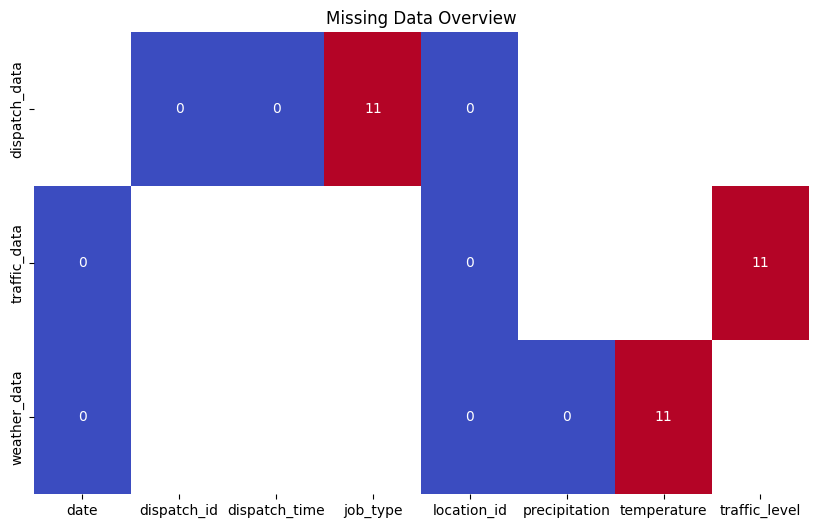

In [9]:
# Missing Data Visualization:

# Combine missing data info
missing_data = pd.DataFrame({
    "dispatch_data": dispatch_data.isnull().sum(),
    "traffic_data": traffic_data.isnull().sum(),
    "weather_data": weather_data.isnull().sum()
})
print("\nSummary of missing data:")
print(missing_data)

# Heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data.T, annot=True, cmap="coolwarm", cbar=False)
plt.title("Missing Data Overview")
plt.show()


# Clean up data issues

In [10]:
# Clean up Dispatch data

# Drop rows with invalid dispatch_time
dispatch_data['dispatch_time'] = pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce')
placeholder_time = pd.Timestamp("2024-01-10 12:00:00")
dispatch_data['dispatch_time'].fillna(placeholder_time, inplace=True)

# Impute invalid location_id with a placeholder (e.g., 101)
dispatch_data.loc[~dispatch_data['location_id'].between(101, 116), 'location_id'] = 101

# Simulate a completion_time column
# Assuming completion time is 5 to 60 minutes after dispatch time
dispatch_data['completion_time'] = pd.to_datetime(dispatch_data['dispatch_time']) + pd.to_timedelta(
    np.random.randint(5, 61, size=len(dispatch_data)), unit='m'
)

# Calculate delay in minutes
dispatch_data['delay_minutes'] = (
    (dispatch_data['completion_time'] - pd.to_datetime(dispatch_data['dispatch_time'])).dt.total_seconds() / 60
)

# Extract date from dispatch_time
# Convert dispatch_time to datetime and extract the date while keeping datetime64[ns]
dispatch_data['date'] = pd.to_datetime(dispatch_data['dispatch_time']).dt.floor('d')

# View cleaned data
print("\nCleaned dispatch_data:")
print(dispatch_data.head())
print(dispatch_data.shape)
print(dispatch_data.dtypes)


Cleaned dispatch_data:
   dispatch_id  location_id       job_type                 dispatch_time  \
0            1          106  fuel_delivery 2024-01-02 08:47:37.867155968   
1            2          106  fuel_delivery 2024-01-03 23:29:39.787000320   
2            3          112    tire_change 2024-01-03 11:09:58.744973312   
3            4          113   battery_jump 2024-01-01 12:23:25.783618048   
4            5          111        lockout 2024-01-01 15:50:39.269447424   

                completion_time  delay_minutes       date  
0 2024-01-02 09:23:37.867155968           36.0 2024-01-02  
1 2024-01-03 23:41:39.787000320           12.0 2024-01-03  
2 2024-01-03 11:41:58.744973312           32.0 2024-01-03  
3 2024-01-01 12:29:25.783618048            6.0 2024-01-01  
4 2024-01-01 16:19:39.269447424           29.0 2024-01-01  
(500, 7)
dispatch_id                 int64
location_id                 int64
job_type                   object
dispatch_time      datetime64[ns]
completion_tim

In [11]:
# Clean up Traffic Data

# Convert invalid dates to NaT and drop them
traffic_data['date'] = pd.to_datetime(traffic_data['date'], errors='coerce')
traffic_data.dropna(subset=['date'], inplace=True)

# Replace invalid location_id with a valid random one between 101 and 116
traffic_data.loc[~traffic_data['location_id'].between(101, 116), 'location_id'] = np.random.choice(range(101, 117))

# Impute missing traffic levels with 'moderate'
traffic_data['traffic_level'].fillna('moderate', inplace=True)

# Diagnose multi-valued location-days
print(
    traffic_data.groupby(['location_id', 'date']).size()
    .reset_index(name='dupes')
    .sort_values('dupes', ascending=False)
)

# Consolidate multiple values per location-day to a single mode
traffic_data = (
    traffic_data.groupby(['location_id', 'date'])['traffic_level']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index()
)

# Confirm uniqueness
max_dupe = (traffic_data.groupby(['location_id', 'date']).size()
            .reset_index(name='dupe_check')['dupe_check'].max())
print("Max duplication after consolidation:", max_dupe)

# Preview cleaned data
print("\nCleaned traffic_data:")
print(traffic_data.head())
print("Shape:", traffic_data.shape)
print(traffic_data.dtypes)


    location_id       date  dupes
53          114 2024-01-02     12
46          112 2024-01-03     12
5           102 2024-01-02     12
9           103 2024-01-02     12
13          104 2024-01-02     10
40          111 2024-01-01     10
36          110 2024-01-01     10
29          108 2024-01-02     10
30          108 2024-01-03      9
16          105 2024-01-01      9
59          115 2024-01-04      9
35          109 2024-01-04      8
22          106 2024-01-03      8
37          110 2024-01-02      8
42          111 2024-01-03      8
12          104 2024-01-01      8
43          111 2024-01-04      8
33          109 2024-01-02      8
45          112 2024-01-02      8
3           101 2024-01-04      8
50          113 2024-01-03      8
25          107 2024-01-02      8
14          104 2024-01-03      8
51          113 2024-01-04      7
54          114 2024-01-03      7
38          110 2024-01-03      7
10          103 2024-01-03      7
57          115 2024-01-02      7
18          10

In [12]:
# Clean up Weather data

# Drop rows with invalid dates
weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
weather_data = weather_data.dropna(subset=['date'])

# Replace invalid precipitation with 0
weather_data.loc[weather_data['precipitation'] < 0, 'precipitation'] = 0

# Impute missing temperatures with the column mean
weather_data['temperature'].fillna(weather_data['temperature'].mean(), inplace=True)

# Are there multiple weather values per location-day?
print(weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupes').sort_values('dupes', ascending = False))
# A: Yes

# Enforce a single value per location-day
weather_data = (
    weather_data.groupby(['location_id', 'date'])
    # These fancy functions for mode are to get around the case where there's multiple modes per group - which would return a series and cause issues in the results,
    .agg(temperature=('temperature', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
         precipitation=('precipitation', lambda x: x.mode().iloc[0] if not x.mode().empty else None))
    .reset_index()
)

# Validate uniqueness, should get 1 as a result
weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupe_check')['dupe_check'].max() 

# Preview cleaned data
print("\nCleaned weather_data:")
print(weather_data.head())
print(weather_data.dtypes)


    location_id       date  dupes
39          114 2024-01-01     13
36          113 2024-01-01     12
7           103 2024-01-02     11
34          112 2024-01-02     10
35          112 2024-01-03     10
..          ...        ...    ...
12          105 2024-01-01      2
11          104 2024-01-03      2
55          119 2024-01-02      2
4           102 2024-01-02      2
45          116 2024-01-01      1

[72 rows x 3 columns]

Cleaned weather_data:
   location_id       date  temperature  precipitation
0          101 2024-01-01         86.3           0.02
1          101 2024-01-02         62.8           0.50
2          101 2024-01-03         65.3           0.15
3          102 2024-01-01         68.3           0.71
4          102 2024-01-02         77.9           0.19
location_id               int64
date             datetime64[ns]
temperature             float64
precipitation           float64
dtype: object


# Visualize cleaned data

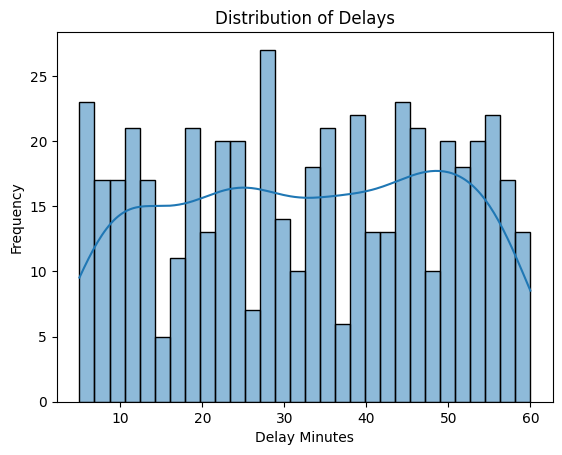

In [13]:
# EDA: Distribution of delays
sns.histplot(dispatch_data['delay_minutes'], kde=True, bins=30)
plt.title('Distribution of Delays')
plt.xlabel('Delay Minutes')
plt.ylabel('Frequency')
plt.show()

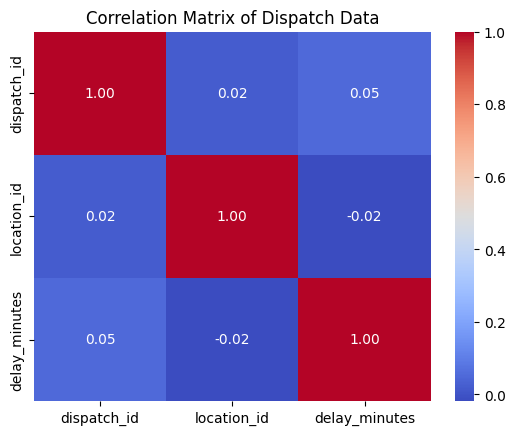

In [14]:
# Correlation heatmap for dispatch data
corr_matrix = dispatch_data.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Dispatch Data')
plt.show()

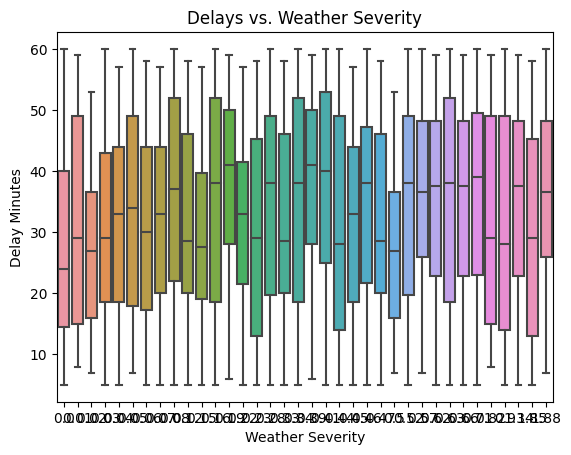

In [15]:
# EDA: Plot delays against weather severity
merged_data = pd.merge(dispatch_data, weather_data, on='location_id', how='left')
sns.boxplot(data=merged_data, x='precipitation', y='delay_minutes')
plt.title('Delays vs. Weather Severity')
plt.xlabel('Weather Severity')
plt.ylabel('Delay Minutes')
plt.show()

# Dataset Merging and EDA/Validate post-merge & filtering

In [16]:
# Add source flags
dispatch_data['source_dispatch'] = 1
traffic_data['source_traffic'] = 1
weather_data['source_weather'] = 1


In [17]:
# How unique is a location-day in the dispatch data?
dispatch_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
8,103,2024-01-03,19
18,107,2024-01-01,18
17,106,2024-01-03,16
2,101,2024-01-03,16
6,103,2024-01-01,16
7,103,2024-01-02,15
39,113,2024-01-03,15
21,108,2024-01-01,15
36,112,2024-01-03,14
26,109,2024-01-03,14


In [18]:
# How unique is a location-day in the traffic data?
traffic_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
0,101,2024-01-01,1
1,101,2024-01-02,1
32,109,2024-01-01,1
33,109,2024-01-02,1
34,109,2024-01-03,1
35,109,2024-01-04,1
36,110,2024-01-01,1
37,110,2024-01-02,1
38,110,2024-01-03,1
39,110,2024-01-04,1


In [19]:
# How unique is a location-day in the weather data?
weather_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
0,101,2024-01-01,1
1,101,2024-01-02,1
52,118,2024-01-02,1
51,118,2024-01-01,1
50,117,2024-01-03,1
...,...,...,...
23,108,2024-01-03,1
22,108,2024-01-02,1
21,108,2024-01-01,1
20,107,2024-01-03,1


## Show how to analyze a full join. This type of analysis is not necessary for this project, but this is shown for completeness of analysis.

In [20]:
# Merge datasets with outer join to include all rows
merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='outer')
merged_data = pd.merge(merged_data, weather_data, on=['location_id', 'date'], how='outer')

# Fill missing flags with 0 (indicating no match from that table)
merged_data['source_dispatch'] = merged_data['source_dispatch'].fillna(0).astype(int)
merged_data['source_traffic'] = merged_data['source_traffic'].fillna(0).astype(int)
merged_data['source_weather'] = merged_data['source_weather'].fillna(0).astype(int)



In [21]:
# Find only the intersection of all 3 datasets
merged_all_three = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]

percent_all_three = len(merged_all_three) / len(merged_data) * 100
print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")


Percentage of rows that merged across all three datasets: 92.07%


In [22]:
# View the full-joined data
merged_data

,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 09:23:37.867155968,36.0,2024-01-02,1,high,1,64.8,0.23,1
1,21.0,106,NaN,2024-01-02 02:03:59.099144448,2024-01-02 02:48:59.099144448,45.0,2024-01-02,1,high,1,64.8,0.23,1
2,48.0,106,lockout,2024-01-02 07:31:22.194818816,2024-01-02 07:36:22.194818816,5.0,2024-01-02,1,high,1,64.8,0.23,1
3,229.0,106,towing,2024-01-02 11:06:20.581702912,2024-01-02 11:26:20.581702912,20.0,2024-01-02,1,high,1,64.8,0.23,1
4,288.0,106,tire_change,2024-01-02 20:54:30.782547968,2024-01-02 21:22:30.782547968,28.0,2024-01-02,1,high,1,64.8,0.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,NaN,123,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,73.4,0.90,1
538,NaN,123,NaN,NaT,NaT,NaN,2024-01-03,0,NaN,0,73.7,0.20,1
539,NaN,124,NaN,NaT,NaT,NaN,2024-01-01,0,NaN,0,61.2,1.54,1
540,NaN,124,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,75.4,0.07,1


In [23]:
# Rows only in dispatch_data
only_dispatch = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 0)
]
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100

# Rows only in traffic_data
only_traffic = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100

# Rows only in weather_data
only_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]
percent_only_weather = len(only_weather) / len(weather_data) * 100

# Dispatch x Traffic only
dispatch_and_traffic = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]

# Dispatch x Weather only
dispatch_and_weather = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]

# Traffic x Weather only
traffic_and_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]


In [24]:
# Finda any rows from any dataset that might be missing
unmatched_rows = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 0)
]

print(f"Number of rows not matched with any dataset: {len(unmatched_rows)}")


Number of rows not matched with any dataset: 0


In [25]:
# Total rows in merged_data
total_rows = len(merged_data)

# Percentages
percent_all_three = len(merged_all_three) / total_rows * 100
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100
percent_only_weather = len(only_weather) / len(weather_data) * 100

print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")
print(f"Percentage of rows only in dispatch_data: {percent_only_dispatch:.2f}%")
print(f"Percentage of rows only in traffic_data: {percent_only_traffic:.2f}%")
print(f"Percentage of rows only in weather_data: {percent_only_weather:.2f}%")


Percentage of rows that merged across all three datasets: 92.07%
Percentage of rows only in dispatch_data: 0.20%
Percentage of rows only in traffic_data: 25.00%
Percentage of rows only in weather_data: 37.50%


In [26]:
print(dispatch_data.shape)
print(traffic_data.shape)
print(weather_data.shape)
merged_data

(500, 8)
(60, 4)
(72, 5)


,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 09:23:37.867155968,36.0,2024-01-02,1,high,1,64.8,0.23,1
1,21.0,106,NaN,2024-01-02 02:03:59.099144448,2024-01-02 02:48:59.099144448,45.0,2024-01-02,1,high,1,64.8,0.23,1
2,48.0,106,lockout,2024-01-02 07:31:22.194818816,2024-01-02 07:36:22.194818816,5.0,2024-01-02,1,high,1,64.8,0.23,1
3,229.0,106,towing,2024-01-02 11:06:20.581702912,2024-01-02 11:26:20.581702912,20.0,2024-01-02,1,high,1,64.8,0.23,1
4,288.0,106,tire_change,2024-01-02 20:54:30.782547968,2024-01-02 21:22:30.782547968,28.0,2024-01-02,1,high,1,64.8,0.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,NaN,123,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,73.4,0.90,1
538,NaN,123,NaN,NaT,NaT,NaN,2024-01-03,0,NaN,0,73.7,0.20,1
539,NaN,124,NaN,NaT,NaT,NaN,2024-01-01,0,NaN,0,61.2,1.54,1
540,NaN,124,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,75.4,0.07,1


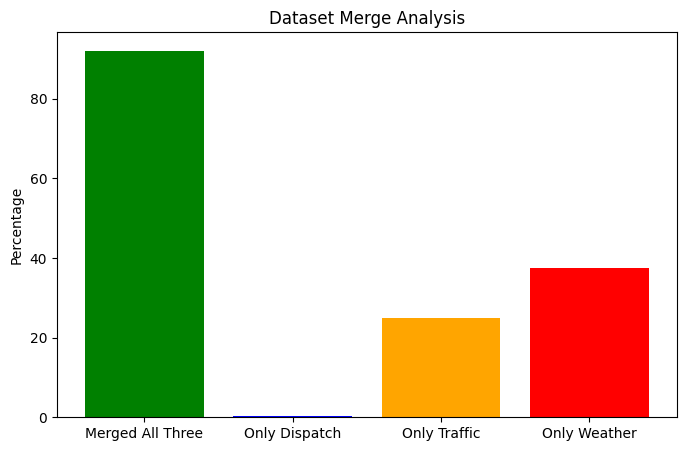

In [27]:
# Data for visualization
categories = ['Merged All Three', 'Only Dispatch', 'Only Traffic', 'Only Weather']
values = [percent_all_three, percent_only_dispatch, percent_only_traffic, percent_only_weather]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'blue', 'orange', 'red'])
plt.ylabel('Percentage')
plt.title('Dataset Merge Analysis')
plt.show()


In [28]:
# Total rows classified
total_rows_accounted_for = (
    len(merged_all_three) +
    len(only_dispatch) +
    len(only_traffic) +
    len(only_weather) +
    len(dispatch_and_traffic) +
    len(dispatch_and_weather) +
    len(traffic_and_weather)
)

# Compare with merged_data
print(f"Total rows accounted for: {total_rows_accounted_for}")
print(f"Total rows in merged_data: {len(merged_data)}")


Total rows accounted for: 542
Total rows in merged_data: 542


## Dispatch data left joining in traffic and weather for modeling

In [29]:
# Merge datasets with outer join to include all rows
left_merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='left')
left_merged_data = pd.merge(left_merged_data, weather_data, on=['location_id', 'date'], how='left')

# Fill missing flags with 0 (indicating no match from that table)
left_merged_data['source_dispatch'] = left_merged_data['source_dispatch'].fillna(0)
left_merged_data['source_traffic'] = left_merged_data['source_traffic'].fillna(0)
left_merged_data['source_weather'] = left_merged_data['source_weather'].fillna(0)

# Convert flags to integers
left_merged_data['source_dispatch'] = left_merged_data['source_dispatch'].astype(int)
left_merged_data['source_traffic'] = left_merged_data['source_traffic'].astype(int)
left_merged_data['source_weather'] = left_merged_data['source_weather'].astype(int)

left_merged_data.head()

,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 09:23:37.867155968,36.0,2024-01-02,1,high,1,64.8,0.23,1
1,2,106,fuel_delivery,2024-01-03 23:29:39.787000320,2024-01-03 23:41:39.787000320,12.0,2024-01-03,1,low,1,61.4,0.06,1
2,3,112,tire_change,2024-01-03 11:09:58.744973312,2024-01-03 11:41:58.744973312,32.0,2024-01-03,1,moderate,1,61.2,0.66,1
3,4,113,battery_jump,2024-01-01 12:23:25.783618048,2024-01-01 12:29:25.783618048,6.0,2024-01-01,1,high,1,62.3,0.45,1
4,5,111,lockout,2024-01-01 15:50:39.269447424,2024-01-01 16:19:39.269447424,29.0,2024-01-01,1,high,1,67.5,0.05,1


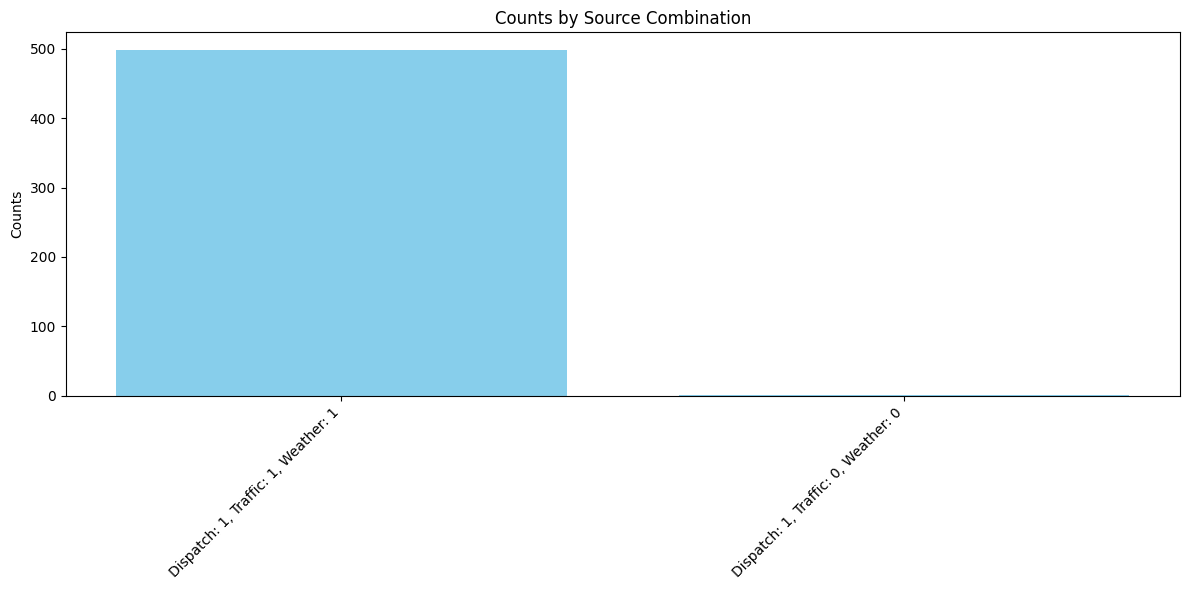

In [30]:
# Plot bar chart of these intersections
source_counts = left_merged_data.groupby(['source_dispatch', 'source_traffic', 'source_weather']).size().reset_index(name = 'counts').sort_values('counts', ascending = False)

source_counts['source_label'] = (
    "Dispatch: " + source_counts['source_dispatch'].astype(str) + 
    ", Traffic: " + source_counts['source_traffic'].astype(str) + 
    ", Weather: " + source_counts['source_weather'].astype(str)
)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(source_counts['source_label'], source_counts['counts'], color='skyblue')

# Customize the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Counts')
plt.title('Counts by Source Combination')
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
# Unique keys in each dataset
dispatch_keys = dispatch_data[['location_id', 'date']].drop_duplicates()
traffic_keys = traffic_data[['location_id', 'date']].drop_duplicates()
weather_keys = weather_data[['location_id', 'date']].drop_duplicates()

# Keys not matched in traffic
missing_in_traffic = dispatch_keys.merge(traffic_keys, on=['location_id','date'], how='left', indicator=True)
missing_in_traffic = missing_in_traffic[missing_in_traffic['_merge'] == 'left_only']

print("Rows in dispatch_data that are missing in traffic_data:")
print(missing_in_traffic.head())
print(f"Count missing: {len(missing_in_traffic)}")

# Keys not matched in weather
missing_in_weather = dispatch_keys.merge(weather_keys, on=['location_id','date'], how='left', indicator=True)
missing_in_weather = missing_in_weather[missing_in_weather['_merge'] == 'left_only']

print("Rows in dispatch_data that are missing in weather_data:")
print(missing_in_weather.head())
print(f"Count missing: {len(missing_in_weather)}")


Rows in dispatch_data that are missing in traffic_data:
    location_id       date     _merge
25          109 2024-01-10  left_only
Count missing: 1
Rows in dispatch_data that are missing in weather_data:
    location_id       date     _merge
25          109 2024-01-10  left_only
Count missing: 1


In [32]:
print("Row count in final merged data:", len(left_merged_data))

nan_summary = left_merged_data[['traffic_level', 'temperature', 'precipitation']].isnull().sum()
print(nan_summary)


Row count in final merged data: 500
traffic_level    1
temperature      1
precipitation    1
dtype: int64


# Export for later

In [33]:
# Save cleaned data for further analysis
dispatch_data.to_csv('data/cleaned_dispatch_data.csv', index=False)
traffic_data.to_csv('data/cleaned_traffic_data.csv', index=False)
weather_data.to_csv('data/cleaned_weather_data.csv', index=False)
left_merged_data.to_csv('data/left_merged_data.csv', index=False)
